In [1]:
import os
os.chdir('/workspace/FutureGPT2/src/')

import numpy as np
from torch import optim, nn, Tensor
from torch.nn import functional as F
import torch
import wandb
from transformers import GPT2Config, GPT2Model
import transformers
import lightning as L
from inspect import signature, _ParameterKind
import copy
import gc
import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from itertools import repeat

from models.regression_model import *
from data.synthetic import *
from models.myopic_model import to_myopic_gpt2

%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.get_device_capability()[0] >= 8:
    torch.set_float32_matmul_precision('high')

In [3]:
class TopoSineDataset(Dataset):
    def __init__(self, size, seq_len=64):
        super().__init__()
        self.size = size
        self.seq_len = seq_len

    def __len__(self):
        return self.size

    def __getitem__(self, value):
        x = torch.normal(0, 1, (1,)).expand(self.seq_len).unsqueeze(-1)
        y = 10*torch.sin(10 / x).nan_to_num(0)
        return {'x': x, 'y': y}

In [4]:
fixed_data_params = {
    'seq_len': 64,
}
free_data_params = dict()
data_params = {**fixed_data_params, **free_data_params}

fixed_model_params = {
    'warmup_steps': 1000,
    'attn_pdrop': 0,
    'embd_pdrop': 0,
    'resid_pdrop': 0,
    'n_inner': None, # MLP inner size; None=4x
    'n_positions': 64,
    'in_dim': 1,
}
free_model_params = {
    'lr': 1e-3,
    'n_embd': 256,
    'n_head': 4,
    'n_layer': 4,
    'activation_function': 'relu',
}
model_params = {**fixed_model_params, **free_model_params}

In [5]:
train = DataLoader(TopoSineDataset(size=1_000_000, **data_params), batch_size=512, num_workers=50)
val = DataLoader(TopoSineDataset(size=10000, **data_params), batch_size=512, num_workers=50)

In [6]:
batch = next(iter(val))

In [7]:
NAME = '_'.join(
    ['SYNTH-GPT2-TOPOSINE'] + 
    [f'{k}-{v}' for k, v in {**free_data_params, **free_model_params}.items()]
)
PROJ = 'LAISR_FUTURE_SYNTHETIC'
wandb.login(key='os.environ[WANDB_API_KEY]', relogin=True)
wandb_logger = WandbLogger(
    name=NAME,
    project=PROJ,
    log_model=False,   # Only save checkpoints locally
)
lr_monitor = LearningRateMonitor()
checkpoint_callback = ModelCheckpoint(
    dirpath="/home/wwu/checkpoints",
    filename=NAME + "_{global_step}_{val_loss:.2f}",
    every_n_epochs=1,
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    divergence_threshold=10000,
    min_delta=0.00,
    patience=100000,
    verbose=False,
    mode='min',
)
trainer = L.Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    val_check_interval=1.0,
    #check_val_every_n_epoch=5,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    max_epochs=100000,
    enable_progress_bar=True,
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/wwu/.netrc
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [8]:
model = LitGPT2RegModel(**model_params)
wandb_logger.watch(model.model, log='all')

wandb: Currently logged in as: wilswu. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [9]:
trainer.fit(
    model=model,
    train_dataloaders=train,
    val_dataloaders=val,
)

/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /home/wwu/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | model   | GPT2Model | 3.2 M 
1 | loss_fn | MSELoss   | 0     
--------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.707    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [55]:
torch.set_grad_enabled(False)

In [56]:
gc.collect(); torch.cuda.empty_cache()

In [26]:
loss, total = 0, 0
for batch in tqdm(iter(train)):
    batch = {k: v.to('cuda') for k, v in batch.items()}
    out = model(batch)
    loss += ((out - batch['y']) ** 2).mean(dim=0).flatten()
    total += 1

  0%|          | 0/1954 [00:00<?, ?it/s]

In [27]:
loss /= total

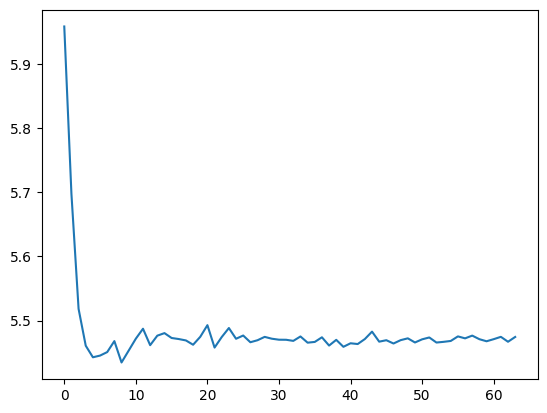

wandb: Network error (ReadTimeout), entering retry loop.


In [28]:
plt.plot(loss.detach().cpu().numpy())

In [57]:
x = torch.arange(-1, 1, 0.0001).reshape((-1, 1)).expand(-1, 64).unsqueeze(-1).to('cuda')

In [58]:
out = model({'x': x})

In [59]:
loss = torch.abs(out - 10*torch.sin(10 / x))**2

In [60]:
out = out.cpu().numpy()

In [61]:
loss = loss.cpu().numpy()

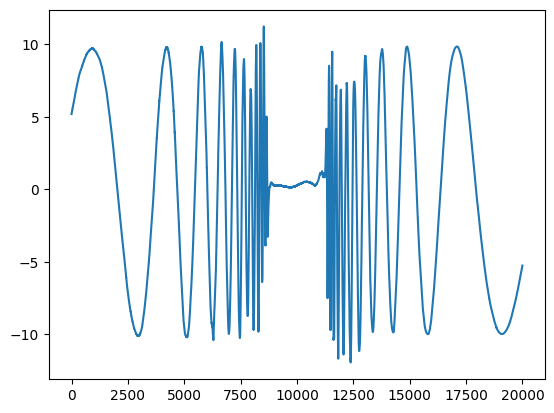

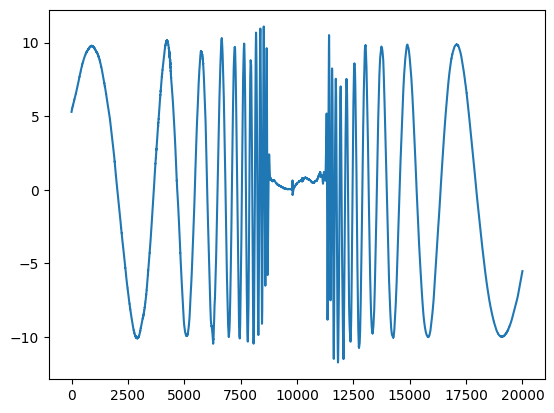

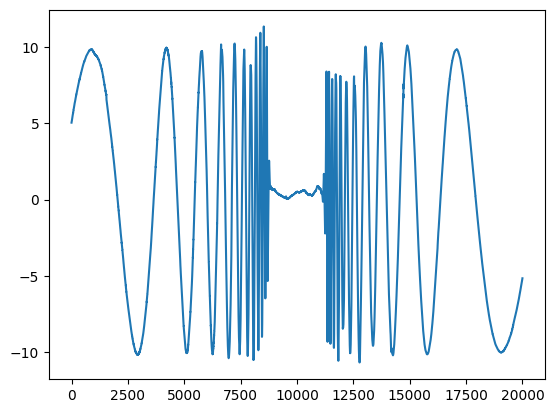

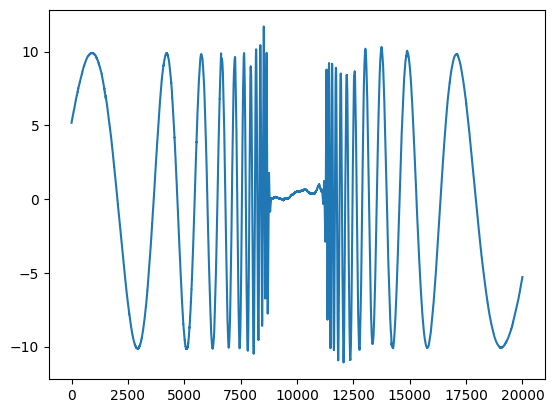

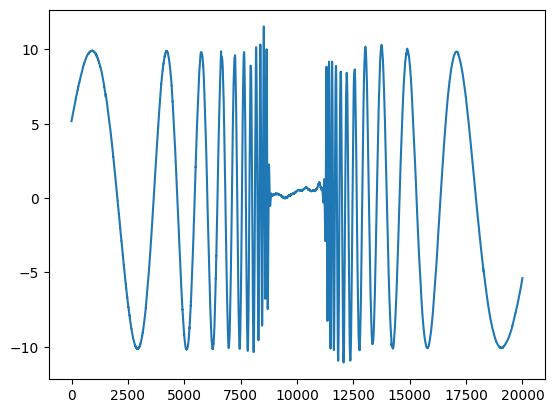

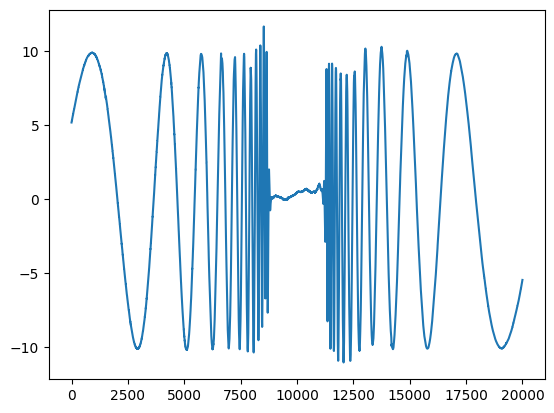

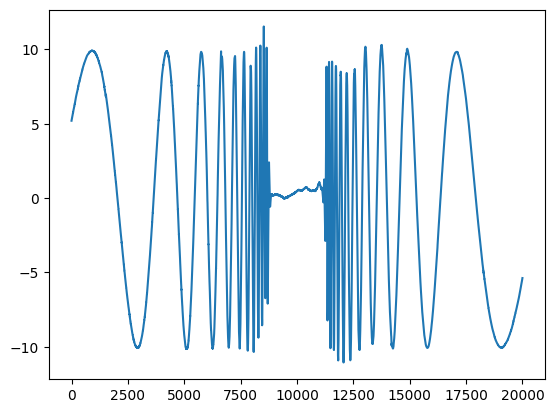

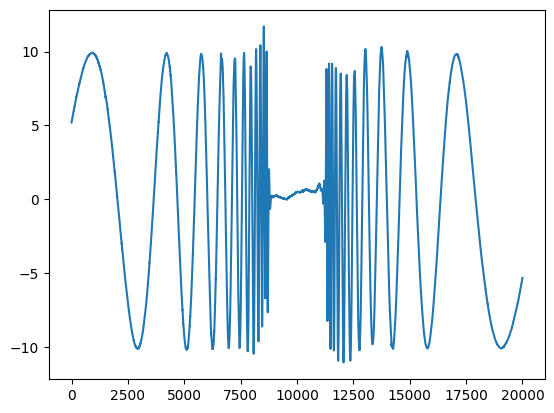

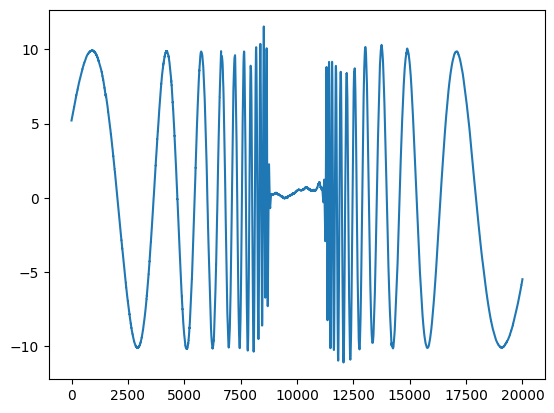

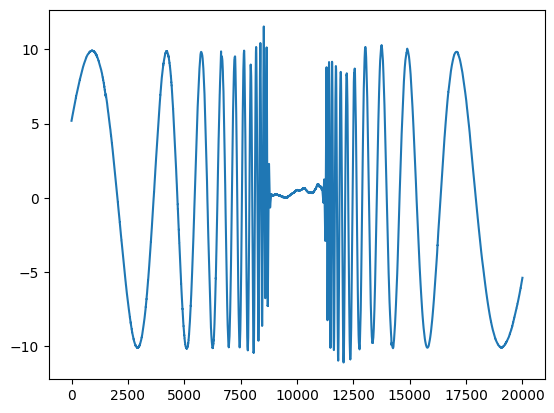

In [63]:
plt.plot(out[:,0,0])
plt.show()
for i in range(1, 10):
    plt.plot(out[:,i,0])
    #plt.plot(loss[:,i,0] - loss[:,i-1,0]),# alpha=0.1)
    plt.show()

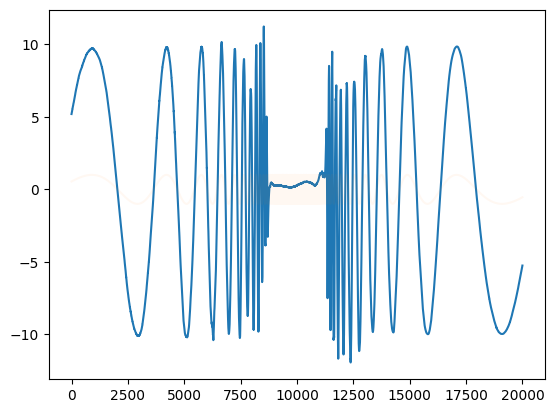

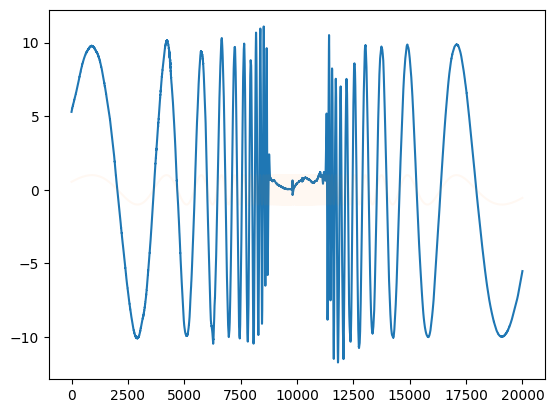

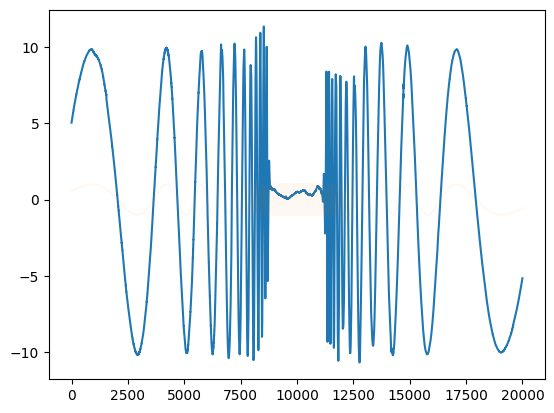

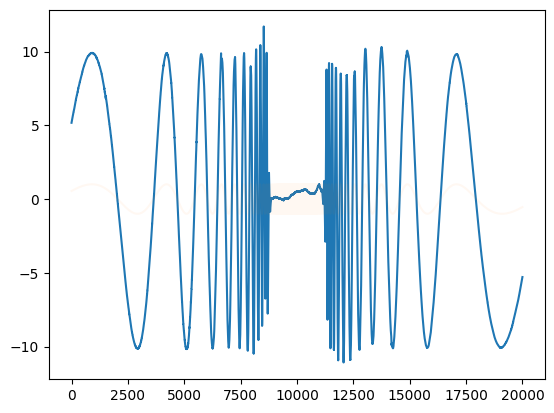

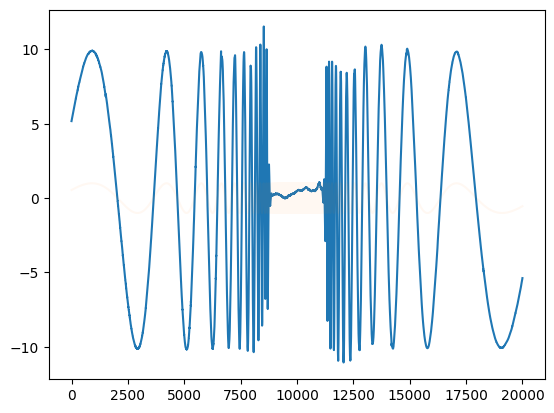

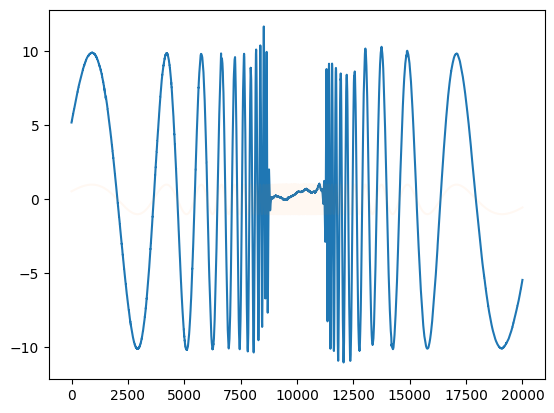

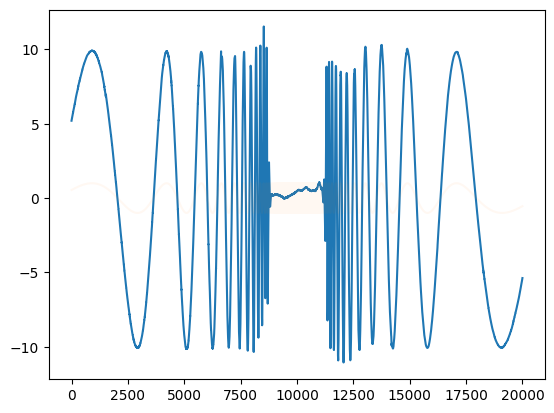

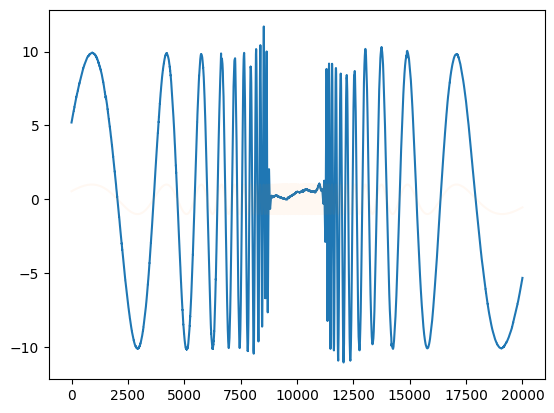

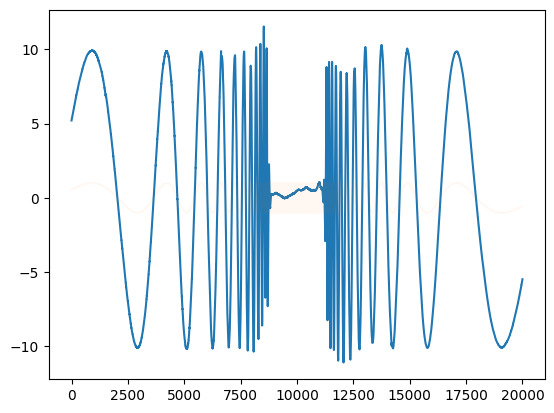

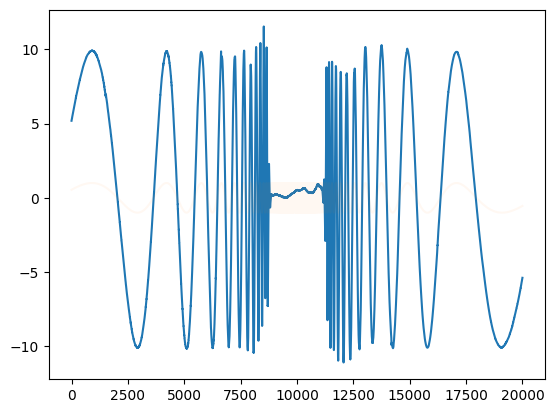

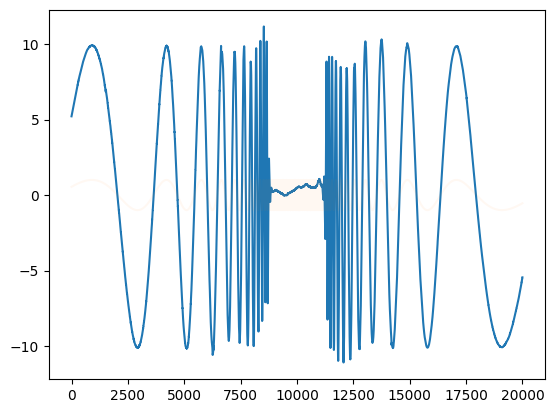

In [64]:
plt.plot(out[:,0,0])
plt.plot(torch.sin(10/x[:,0,0]).cpu().numpy(), alpha=0.05)
plt.show()
for i in range(10):
    plt.plot(out[:,i+1,0]) #- out[:,i,0])
    plt.plot(torch.sin(10/x[:,0,0]).cpu().numpy(), alpha=0.05)
    plt.show()

In [22]:
y = torch.sin(10/x[:,0,0]).cpu().numpy()

In [23]:
from matplotlib.animation import FuncAnimation
def update(frame):
    plt.clf()
    plt.plot(out[:,t,0])
    plt.plot(y, alpha=0.1)
    plt.title(f't={t}')

fig, ax = plt.subplots()
ani = FuncAnimation(fig, update, frames=64, interval=200)
ani.save('ani.gif')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x7f1efbe02ef0> (for post_execute), with arguments args (),kwargs {}:


NameError: name 't' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.imshow(loss[:,:,0], aspect='auto', extent=[0, 64, -1, 1])
plt.colorbar()
plt.show()